Phân tích biến động giá cổ phiếu PNJ <br>
Người thực hiện: Đỗ Việt Bách <br>
Phone: 0559 686 243 <br>
Email: 19521230@gm.uit.edu.vn <br>
Dataset: Giá trị cổ phiếu PNJ từ ngày 28/02/2018 tới ngày 22/12/2020 <br>
Mô hình dự báo: RNN vs. GRU

##Import dữ liệu và thư viện cần thiết

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PNJ.csv to PNJ.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/PNJ.csv')

In [4]:
df

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,PNJ,2/28/2018 9:15,78.14,78.99,78.14,78.99,270,0
1,PNJ,2/28/2018 9:16,78.94,78.94,78.94,78.94,10,0
2,PNJ,2/28/2018 9:19,78.14,78.14,78.14,78.14,283,0
3,PNJ,2/28/2018 9:20,78.14,78.14,78.14,78.14,480,0
4,PNJ,2/28/2018 9:21,78.14,78.14,78.14,78.14,146,0
...,...,...,...,...,...,...,...,...
125304,PNJ,12/22/2020 14:22,78.20,78.20,78.20,78.20,5000,0
125305,PNJ,12/22/2020 14:23,78.20,78.20,78.20,78.20,1700,0
125306,PNJ,12/22/2020 14:24,78.20,78.20,78.20,78.20,870,0
125307,PNJ,12/22/2020 14:25,78.10,78.10,78.10,78.10,13000,0


##Làm sạch dữ liệu

In [5]:
# Xem kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125309 entries, 0 to 125308
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Ticker         125309 non-null  object 
 1   Date/Time      125309 non-null  object 
 2   Open           125309 non-null  float64
 3   High           125309 non-null  float64
 4   Low            125309 non-null  float64
 5   Close          125309 non-null  float64
 6   Volume         125309 non-null  int64  
 7   Open Interest  125309 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 7.6+ MB


In [6]:
df.dtypes

Ticker            object
Date/Time         object
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
Open Interest      int64
dtype: object

In [7]:
# Kiểm tra hàng trùng lặp
df.duplicated().any()

False

In [8]:
# Kiểm tra Null
df.isnull().any()

Ticker           False
Date/Time        False
Open             False
High             False
Low              False
Close            False
Volume           False
Open Interest    False
dtype: bool

In [9]:
# Kiểm tra các giá trị min, max, mean(giá trị trung bình), standard(độ lệch chuẩn) của mỗi cột
df.describe()

,Open,High,Low,Close,Volume,Open Interest
count,125309.000000,125309.000000,125309.000000,125309.000000,125309.000000,125309.0
mean,72.182052,72.372590,72.042287,72.179371,3031.830451,0.0
std,9.900263,9.995786,9.830847,9.899401,7248.952968,0.0
min,44.430000,44.530000,44.040000,44.140000,1.000000,0.0
25%,64.600000,64.700000,64.570000,64.600000,220.000000,0.0
50%,72.800000,73.010000,72.640000,72.830000,1000.000000,0.0
75%,80.160000,80.350000,80.060000,80.160000,3130.000000,0.0
max,100.160000,100.160000,100.160000,100.160000,580730.000000,0.0


In [10]:
import matplotlib.pyplot as plt

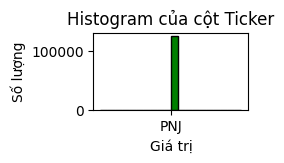

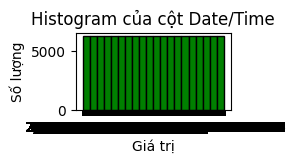

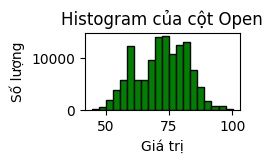

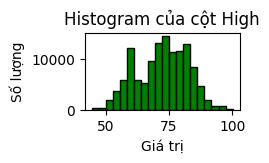

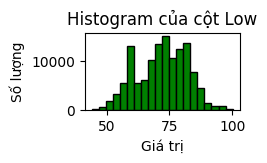

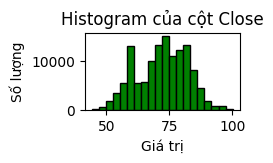

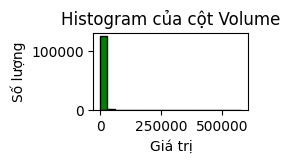

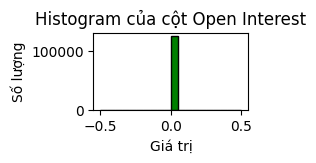

In [11]:
# Sử dụng Histogram để kiểm tra sự phân bổ giá trị trong mỗi cột
for column in df.columns:
    plt.figure(figsize=(2, 1))
    plt.hist(df[column], bins=20, color='green', edgecolor='black')
    plt.title(f'Histogram của cột {column}')
    plt.xlabel('Giá trị')
    plt.ylabel('Số lượng')
    plt.show()

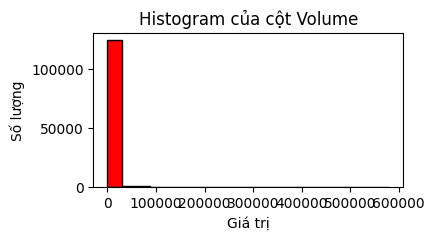

In [12]:
plt.figure(figsize=(4, 2))
plt.hist(df['Volume'], bins=20, color='red', edgecolor='black')
plt.title('Histogram của cột Volume')
plt.xlabel('Giá trị')
plt.ylabel('Số lượng')
plt.show()

### Nhận xét dữ liệu
+ Cột Volume có sự chênh lệch lớn giữa các giá trị, có thể làm dự báo sai lệch.
+ Ở đây bài toán đặt ra là dự báo giá trị cổ phiếu thì em sẽ sử dụng cột Close làm thuộc tính quyết định để dự báo. Do các cột Open, High, Low có sự tương đồng nên loại bỏ để giảm thời gian thực thi.
+ Để tăng Accuracy của thuật toán thì sẽ sử dụng Scale giá trị cột Close bằng công thức: (Giá trị - min)/(max - min)

In [13]:
df1 = df.reset_index()['Close']
df1 = df1.reset_index(drop=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Scale cột Close và lưu vào mảng
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [17]:
df1

array([[0.62209925],
       [0.62120671],
       [0.6069261 ],
       ...,
       [0.60799714],
       [0.60621207],
       [0.60978222]])

##Phân tích dữ liệu

### Phương pháp sử dụng
- Đề bài là phân tích biến động giá cổ phiếu, ở đây em lựa chọn giá cổ phiếu giờ đóng cửa (Close) để phân tích.
- Đối với tập dữ liệu này có 3 phương pháp phổ biến để phân tích:
  + 1.Phương pháp phân tích chuỗi thời gian (Time Series Analysis): ARIMA, SARIMA ...
  + 2.Phương pháp Machine Learning : Linear Regression, KNN ...
  + 3.Phương pháp Deep Learning
- Với bài toán dự báo xu hướng giá trị em sẽ sử dụng 2 mô hình Recurrent Neural Network (RNN) và mô hình Gated Recurrent Unit (GRU) nằm trong phương pháp Deep Learning. Trong phương pháp này mô hình Long short term memory (LSTM) có Accuracy tốt hơn, nhưng với tập dữ liệu có 125309 dòng thì LSTM có thời gian thực thi lâu hơn rất nhiều do sử dụng nhiều tham số.

In [18]:
# Chia dữ liệu thành 3 phần Train, Test, Validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
train_data

array([[0.62209925],
       [0.62120671],
       [0.6069261 ],
       ...,
       [0.16940378],
       [0.17118886],
       [0.19207426]])

In [20]:
test_data

array([[0.16940378],
       [0.17118886],
       [0.17118886],
       ...,
       [0.30863977],
       [0.30863977],
       [0.30863977]])

In [21]:
val_data

array([[0.30863977],
       [0.30863977],
       [0.30863977],
       ...,
       [0.60799714],
       [0.60621207],
       [0.60978222]])

### Mô hình RNN

In [22]:
# Gọi các thư viện cần thiết để xây dựng RNN
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [23]:
train_data_RNN = train_data
test_data_RNN = test_data
val_data_RNN = val_data

In [24]:
# Hàm Create Dataset để chuyển đổi mảng thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [25]:
# Sử dụng hàm Create Dataset để chuyển đổi các mảng Train, Test, Validate
time_step = 100
x_train_RNN, y_train_RNN = create_dataset(train_data_RNN, time_step)
x_val_RNN, y_val_RNN = create_dataset(val_data_RNN, time_step)
x_test_RNN, y_test_RNN = create_dataset(test_data_RNN, time_step)

In [26]:
# Reshape đầu vào để phù hợp với mô hình RNN
x_train_RNN = x_train_RNN.reshape(x_train_RNN.shape[0], x_train_RNN.shape[1], 1)
x_test_RNN = x_test_RNN.reshape(x_test_RNN.shape[0], x_test_RNN.shape[1], 1)
x_val_RNN = x_val_RNN.reshape(x_val_RNN.shape[0], x_val_RNN.shape[1], 1)

In [27]:
# Khai báo mô hình RNN
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [28]:
# Fit mô hình với dữ liệu Train
model.fit(x_train_RNN, y_train_RNN , validation_data = (x_test_RNN, y_test_RNN),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
1369/1369 [==============================] - 27s 19ms/step - loss: 0.0017 - val_loss: 5.7102e-05
Epoch 2/100
1369/1369 [==============================] - 26s 19ms/step - loss: 1.8248e-04 - val_loss: 3.2963e-05
Epoch 3/100
1369/1369 [==============================] - 28s 20ms/step - loss: 1.6684e-04 - val_loss: 1.5504e-05
Epoch 4/100
1369/1369 [==============================] - 26s 19ms/step - loss: 1.6573e-04 - val_loss: 2.9210e-05
Epoch 5/100
1369/1369 [==============================] - 25s 18ms/step - loss: 1.5823e-04 - val_loss: 7.5193e-05
Epoch 6/100
1369/1369 [==============================] - 25s 18ms/step - loss: 1.5647e-04 - val_loss: 9.1055e-06
Epoch 7/100
1369/1369 [==============================] - 26s 19ms/step - loss: 1.5221e-04 - val_loss: 7.9345e-06
Epoch 8/100
1369/1369 [==============================] - 25s 18ms/step - loss: 1.5193e-04 - val_loss: 1.7683e-05
Epoch 9/100
1369/1369 [==============================] - 24s 18ms/step - loss: 1.5093e-04 - val_loss

In [29]:
# Dự báo dữ liệu train_predict_RNN, y_pred_RNN, y_pred_val_RNN
train_predict_RNN = model.predict(x_train_RNN)
y_pred_RNN = model.predict(x_test_RNN)
y_pred_val_RNN = model.predict(x_val_RNN)

389/389 [==============================] - 2s 5ms/step


In [30]:
# Đảo ngược giá trị dự đoán trên tập Test và Validate về giá trị chuẩn
train_predict_RNN = scaler.inverse_transform(train_predict_RNN)
y_pred_RNN = scaler.inverse_transform(y_pred_RNN)
y_pred_val_RNN = scaler.inverse_transform(y_pred_val_RNN)

In [31]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
real_val_RNN = scaler.inverse_transform(y_val_RNN.reshape(-1, 1))
real_test_RNN = scaler.inverse_transform(y_test_RNN.reshape(-1, 1))

In [32]:
# Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse_RNN = np.sqrt(np.mean((y_pred_RNN - real_test_RNN)**2))
val_rmse_RNN = np.sqrt(np.mean((y_pred_val_RNN - real_val_RNN)**2))
print('Testing RMSE:', test_rmse_RNN)
print('Validation RMSE:', val_rmse_RNN)

Testing RMSE: 0.17981912012194998
Validation RMSE: 0.19397695353241398


In [33]:
# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape_RNN = np.mean((np.absolute(real_test_RNN - y_pred_RNN)/real_test_RNN)*100)
val_mape_RNN = np.mean((np.absolute(real_val_RNN - y_pred_val_RNN)/real_val_RNN)*100)
print('Testing MAPE:', test_mape_RNN)
print('Validation MAPE:', val_mape_RNN)

Testing MAPE: 0.22352091831529025
Validation MAPE: 0.18898133795213765


In [34]:
# Tính phần trăm độ chính xác trên tập Test và Validate
data_range_RNN = df['Close'].max() - df['Close'].min()
test_accuracy_RNN = (1 - test_rmse_RNN / data_range_RNN) * 100
val_accuracy_RNN = (1 - val_rmse_RNN / data_range_RNN) * 100
print('Testing Accuracy (%):', test_accuracy_RNN)
print('Validation Accuracy (%):', val_accuracy_RNN)

Testing Accuracy (%): 99.67900906797225
Validation Accuracy (%): 99.65373624860334


In [36]:
# Dự báo 15 stage tiếp theo
x_input_RNN = val_data_RNN[60:].reshape(1, -1)
x_input_RNN.shape

temp_input_RNN = list(x_input_RNN)
temp_input_RNN = temp_input_RNN[0].tolist()

lst_output_RNN = []
n_steps_RNN = 12471
i = 0
while i < 15:
    if len(temp_input_RNN) > 12471:
          x_input_RNN = np.array(temp_input_RNN[1:])
         #print("{} day input {}".format(i, x_input))
          x_input_RNN = x_input_RNN.reshape(1, -1)
          x_input_RNN = x_input_RNN.reshape((1, n_steps_RNN, 1))
          yhat = model.predict(x_input_RNN, verbose=0)
        #print("{} day output {}".format(i, yhat))
          temp_input_RNN.extend(yhat[0].tolist())
          temp_input_RNN = temp_input_RNN[1:]
          lst_output_RNN.extend(yhat.tolist())
          i = i + 1
    else:
        x_input_RNN = x_input_RNN.reshape((1, n_steps_RNN, 1))
        yhat = model.predict(x_input_RNN, verbose=0)

        temp_input_RNN.extend(yhat[0].tolist())

        lst_output_RNN.extend(yhat.tolist())
        i = i + 1

# Chuẩn hóa lại dự đoán 15 stage
predicted_values_RNN = np.array(lst_output_RNN)
predicted_values_RNN = predicted_values_RNN.reshape(-1, 1)

# Chuẩn hóa dự đoán
predicted_values_RNN = scaler.inverse_transform(predicted_values_RNN)

print("Dự đoán 15 stage tiếp theo:")
print(predicted_values_RNN)

Dự đoán 15 stage tiếp theo:
[[81.14182049]
 [82.01941022]
 [82.4399772 ]
 [82.52678922]
 [82.50155266]
 [82.45925021]
 [82.42081104]
 [82.38483609]
 [82.36245776]
 [82.35131869]
 [82.34638023]
 [82.3430178 ]
 [82.34141506]
 [82.34090084]
 [82.34088415]]


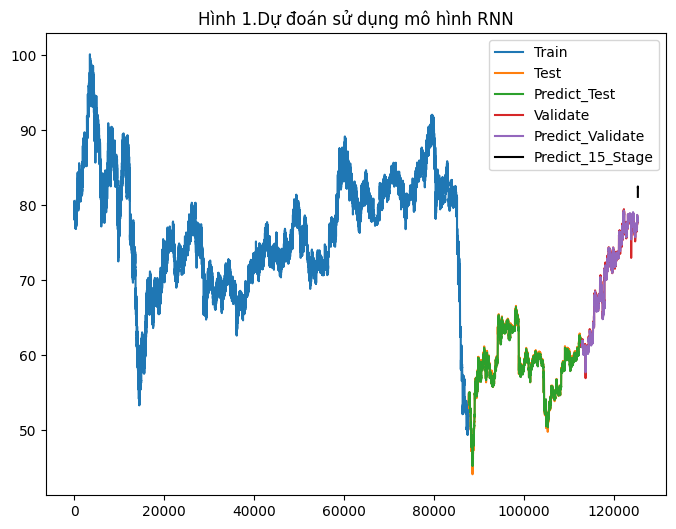

In [56]:
# Vẽ hình
plt.figure(figsize=(8, 6))
train_data_index_RNN = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data_RNN))
test_data_index_RNN = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index_RNN, scaler.inverse_transform(test_data_RNN))
test_data_index_RNN = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index_RNN,(y_pred_RNN))
val_data_index_RNN = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_RNN, scaler.inverse_transform(val_data_RNN))
val_data_index_RNN = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_RNN, y_pred_val_RNN)
predict_data_index_RNN = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_RNN, scaler.inverse_transform(lst_output_RNN), color='black')
plt.title('Hình 1.Dự đoán sử dụng mô hình RNN')
plt.legend(['Train','Test','Predict_Test','Validate','Predict_Validate','Predict_15_Stage'])
plt.show()

#### Nhận xét
- Kết quả dự báo 15 stage tiếp theo bằng mô hình RNN là 10 stage tăng và 5 stage bình ổn.
- Độ chính xác của thuật toán dựa trên các thang đo RMSE và MAPE là rất cao.
- Độ chính xác của thuật toán để dự báo trên tập Test và Validate khoảng 99.6%.
- Nhìn trên ảnh ta thấy:
  + Kết quả dự báo trên tập Test (màu xanh) gần như trùng khớp với kết quả thực tế trên tập Test (màu vàng).
  + Kết quả dự báo trên tập Validate (màu tím) gần như trùng khớp với kết quả thực tế trên tập Validate (đỏ).
- Tuy nhiên mô hình đang dự báo sai sự chuyển tiếp giữa các pha. Giá trị Close ngày gấn nhất là 78.3 nhưng ngày dự báo tiếp theo là 82.14. Nên mô hình này không đáng tin cậy.
- => Nên sử dụng các mô hình như GRU và LSTM để dự báo chính xác hơn.

### Mô hình GRU

In [38]:
# Gọi các thư viện cần thiết để xây dựng RNN
from keras.models import Sequential
from keras.layers import Dense, GRU, BatchNormalization

In [39]:
train_data_GRU = train_data
test_data_GRU = test_data
val_data_GRU = val_data

In [40]:
# Hàm Create Dataset để chuyển đổi mảng thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [41]:
# Sử dụng hàm Create Dataset để chuyển đổi các mảng Train, Test, Validate
time_step = 100
x_train_GRU, y_train_GRU = create_dataset(train_data_GRU, time_step)
x_val_GRU, y_val_GRU = create_dataset(val_data_GRU, time_step)
x_test_GRU, y_test_GRU = create_dataset(test_data_GRU, time_step)

In [42]:
# Reshape đầu vào để phù hợp với mô hình GRU
x_train_GRU = x_train_GRU.reshape(x_train_GRU.shape[0], x_train_GRU.shape[1] , 1)
x_test_GRU = x_test_GRU.reshape(x_test_GRU.shape[0], x_test_GRU.shape[1] , 1)
x_val_GRU = x_val_GRU.reshape(x_val_GRU.shape[0], x_val_GRU.shape[1] , 1)

In [43]:
# Khai báo mô hình GRU
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# 9. Fit mô hình với dữ liệu Train
model.fit(x_train_GRU, y_train_GRU, validation_data = (x_test_GRU, y_test_GRU), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
1369/1369 [==============================] - 67s 48ms/step - loss: 0.0025 - val_loss: 1.7206e-05
Epoch 2/100
1369/1369 [==============================] - 66s 48ms/step - loss: 1.3802e-04 - val_loss: 9.5367e-06
Epoch 3/100
1369/1369 [==============================] - 68s 49ms/step - loss: 1.4276e-04 - val_loss: 2.1976e-05
Epoch 4/100
1369/1369 [==============================] - 70s 51ms/step - loss: 1.4610e-04 - val_loss: 2.6716e-05
Epoch 5/100
1369/1369 [==============================] - 74s 54ms/step - loss: 1.4231e-04 - val_loss: 1.2937e-05
Epoch 6/100
1369/1369 [==============================] - 65s 47ms/step - loss: 1.4333e-04 - val_loss: 8.2351e-06
Epoch 7/100
1369/1369 [==============================] - 64s 47ms/step - loss: 1.4303e-04 - val_loss: 8.2714e-06
Epoch 8/100
1369/1369 [==============================] - 65s 47ms/step - loss: 1.4348e-04 - val_loss: 3.5007e-05
Epoch 9/100
1369/1369 [==============================] - 64s 47ms/step - loss: 1.4085e-04 - val_loss

In [45]:
# Dự báo dữ liệu train_predict_GRU, y_pred_GRU, y_pred_val_GRU
train_predict_GRU = model.predict(x_train_GRU)
y_pred_GRU = model.predict(x_test_GRU)
y_pred_val_GRU = model.predict(x_val_GRU)

389/389 [==============================] - 4s 9ms/step


In [46]:
# Đảo ngược giá trị dự đoán trên tập Test và Validate về giá trị chuẩn
train_predict_GRU = scaler.inverse_transform(train_predict_GRU)
y_pred_GRU = scaler.inverse_transform(y_pred_GRU)
y_pred_val_GRU = scaler.inverse_transform(y_pred_val_GRU)

In [47]:
# Đảo ngược giá trị thực tế của tập Test và Validate về giá trị chuẩn
real_val_GRU = scaler.inverse_transform(y_val_GRU.reshape(-1, 1))
real_test_GRU = scaler.inverse_transform(y_test_GRU.reshape(-1, 1))

In [48]:
# Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse_GRU = np.sqrt(np.mean((y_pred_GRU - real_test_GRU)**2))
val_rmse_GRU = np.sqrt(np.mean((y_pred_val_GRU - real_val_GRU)**2))
print('Testing RMSE:', test_rmse_GRU)
print('Validation RMSE:', val_rmse_GRU)

Testing RMSE: 0.14652024241284295
Validation RMSE: 0.1963521577559302


In [49]:
# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape_GRU = np.mean((np.absolute(real_test_GRU - y_pred_GRU)/real_test_GRU)*100)
val_mape_GRU = np.mean((np.absolute(real_val_GRU - y_pred_val_GRU)/real_val_GRU)*100)
print('Testing MAPE:', test_mape_GRU)
print('Validation MAPE:', val_mape_GRU)

Testing MAPE: 0.16215918927642406
Validation MAPE: 0.17019826174403513


In [50]:
# Tính phần trăm độ chính xác trên tập Test và Validate
data_range_GRU = df['Close'].max() - df['Close'].min()
test_accuracy_GRU = (1 - test_rmse_GRU / data_range_GRU) * 100
val_accuracy_GRU = (1 - val_rmse_GRU / data_range_GRU) * 100
print('Testing Accuracy (%):', test_accuracy_GRU)
print('Validation Accuracy (%):', val_accuracy_GRU)

Testing Accuracy (%): 99.73845012064825
Validation Accuracy (%): 99.64949632674771


In [52]:
# Dự báo 15 stage tiếp theo
x_input_GRU = val_data_GRU[60:].reshape(1, -1)
x_input_GRU.shape

temp_input_GRU = list(x_input_GRU)
temp_input_GRU = temp_input_GRU[0].tolist()

lst_output_GRU = []
n_steps_GRU = 12471
i = 0
while i < 15:
    if len(temp_input_GRU) > 12471:
          x_input_GRU = np.array(temp_input_GRU[1:])

          x_input_GRU = x_input_GRU.reshape(1, -1)
          x_input_GRU = x_input_GRU.reshape((1, n_steps_GRU, 1))
          yhat = model.predict(x_input_GRU, verbose=0)

          temp_input_GRU.extend(yhat[0].tolist())
          temp_input_GRU = temp_input_GRU[1:]
          lst_output_GRU.extend(yhat.tolist())
          i = i + 1
    else:
        x_input_GRU = x_input_GRU.reshape((1, n_steps_GRU, 1))
        yhat = model.predict(x_input_GRU, verbose=0)

        temp_input_GRU.extend(yhat[0].tolist())

        lst_output_GRU.extend(yhat.tolist())
        i = i + 1

# Chuẩn hóa lại dự đoán 15 stage
predicted_values_GRU = np.array(lst_output_GRU)
predicted_values_GRU = predicted_values_GRU.reshape(-1, 1)

# Chuẩn hóa dự đoán
predicted_values_GRU = scaler.inverse_transform(predicted_values_GRU)

print("Dự đoán 15 stage tiếp theo:")
print(predicted_values_GRU)

Dự đoán 15 stage tiếp theo:
[[78.2293322 ]
 [78.23083144]
 [78.23307862]
 [78.23571313]
 [78.23850792]
 [78.24131272]
 [78.24404073]
 [78.24664519]
 [78.24913278]
 [78.2515369 ]
 [78.25388092]
 [78.25620156]
 [78.25851552]
 [78.26082614]
 [78.26313677]]


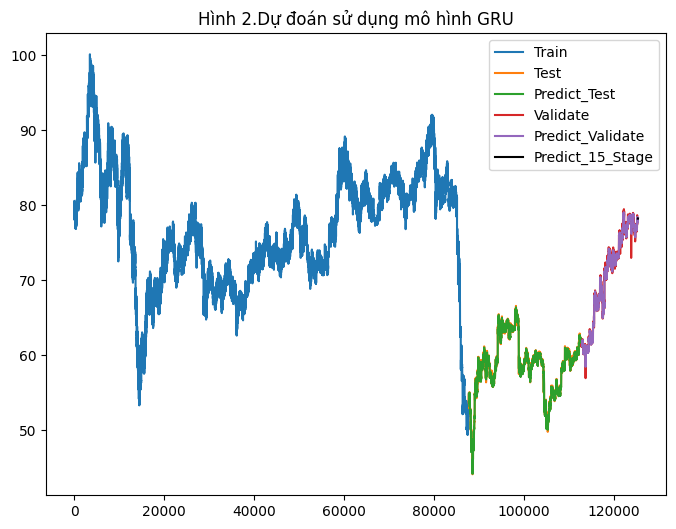

In [53]:
# Vẽ hình
plt.figure(figsize=(8, 6))
train_data_index_GRU = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data_GRU))
test_data_index_GRU = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index_GRU, scaler.inverse_transform(test_data_GRU))
test_data_index_GRU = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index_GRU, (y_pred_GRU))
val_data_index_GRU = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_GRU, scaler.inverse_transform(val_data_GRU))
val_data_index_GRU = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index_GRU, y_pred_val_GRU)
predict_data_index_GRU = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_GRU, scaler.inverse_transform(lst_output_GRU), color='black')
plt.title('Hình 2.Dự đoán sử dụng mô hình GRU')
plt.legend(['Train','Test','Predict_Test','Validate','Predict_Validate','Predict_15_Stage'])
plt.show()

#### Nhận xét
- Kết quả dự báo 15 stage tiếp theo bằng mô hình GRU là 1 stage giảm và 14 stage sau tăng rất nhẹ (tăng nhẹ 0.01).
- Độ chính xác của thuật toán dựa trên các thang đo RMSE và MAPE là rất cao.
- Độ chính xác của thuật toán để dự báo trên tập Test và Validate khoảng 99.7%.
- Nhìn trên ảnh ta thấy:
  + Kết quả dự báo trên tập Test (màu xanh) gần như trùng khớp với kết quả thực tế trên tập Test (màu vàng).
  + Kết quả dự báo trên tập Validate (màu tím) gần như trùng khớp với kết quả thực tế trên tập Validate (đỏ).
- Mô hình GRU dự báo tăng nhẹ trong pha tiếp theo. Trong khi các pha gần nhất hầu như không có sự thay đổi đáng kể.

## Tổng kết

In [54]:
# So sánh 2 mô hình RNN và GRU
data = {
    'Độ đo': ['Test Accuracy (%)', 'Validation Accuracy (%)', 'Test RMSE', 'Validation RMSE', 'Test MAPE', 'Validation MAPE'],
    'Mô hình RNN': [test_accuracy_RNN, val_accuracy_RNN, test_rmse_RNN, val_rmse_RNN, test_mape_RNN, val_mape_RNN],
    'Mô hình GRU': [test_accuracy_GRU, val_accuracy_GRU, test_rmse_GRU, val_rmse_GRU, test_mape_GRU, val_mape_GRU]
}

df = pd.DataFrame(data).set_index('Độ đo')

print(df)

                         Mô hình RNN  Mô hình GRU
Độ đo                                            
Test Accuracy (%)          99.679009    99.738450
Validation Accuracy (%)    99.653736    99.649496
Test RMSE                   0.179819     0.146520
Validation RMSE             0.193977     0.196352
Test MAPE                   0.223521     0.162159
Validation MAPE             0.188981     0.170198


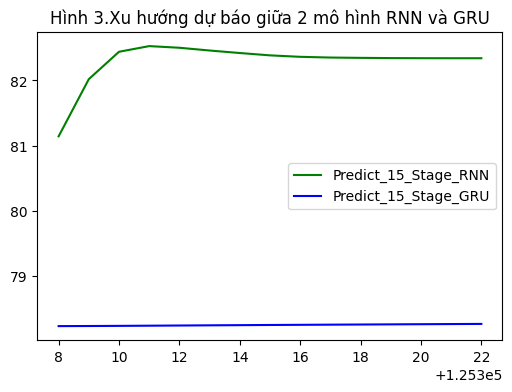

In [55]:
# Nhận xét Predict 15 stage của 2 mô hình
plt.figure(figsize=(6, 4))
predict_data_index_RNN = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_RNN, scaler.inverse_transform(lst_output_RNN), color='green')
predict_data_index_GRU = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+14, step=1)
plt.plot(predict_data_index_GRU, scaler.inverse_transform(lst_output_GRU), color='blue')
plt.title('Hình 3.Xu hướng dự báo giữa 2 mô hình RNN và GRU')
plt.legend(['Predict_15_Stage_RNN', 'Predict_15_Stage_GRU'])
plt.show()

### Tổng kết
- Nhìn ảnh so sánh trên, ta thấy mô hình GRU dự đoán chính xác hơn nhiều mô hình RNN.
- Và xu hướng tăng là rất nhỏ, không đáng kể. Cần xây dựng một mô hình mạnh mẽ hơn như LSTM để có thể đưa ra kết luận chính xác nhất.
- Tuy nhiên, ở đây em mới chỉ phân tích dựa trên giá trị cổ phiếu đóng cửa (Close). Em đã bỏ qua phân tích một thuộc tính khá quan trọng là lưu lượng mua/bán (Volume). Ví dụ, Volume đột ngột tăng mạnh và giá trị Close đột ngột giảm mạnh thể hiện người dùng đang bán xả giá trị cổ phiếu đó. Nên đây sẽ là hướng cải tiến mô hình chính xác hơn nữa, tránh trường hợp bị overfitting.